In [1]:
import numpy as np
from pyproj import Geod
from openquake.hazardlib.contexts import RuptureContext, DistancesContext, SitesContext
from openquake.hazardlib.gsim.boore_2014 import BooreEtAl2014
from openquake.hazardlib.gsim.kanno_2006 import Kanno2006Shallow, Kanno2006Deep
from openquake.hazardlib.gsim.zhao_2016 import ZhaoEtAl2016Asc
from openquake.hazardlib import imt, const
from einops import rearrange
from utils import (SeismicParameters, evaluate_ratio, calculate_distance_binned_ratios,
                   ratio_gmm_pgv, moving_average_envelope_adaptive, fft)
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16})

geod = Geod(ellps="WGS84")

def epicentral_distance(lat_src, lon_src, lat_sta, lon_sta):
    """Great‑circle surface distance [km]."""
    _, _, dist_m = geod.inv(lon_src, lat_src, lon_sta, lat_sta)
    return dist_m / 1_000.0

def point_source_distances(lat_src, lon_src, depth_km,
                           lat_sta, lon_sta):
    """
    Return (R_epi, R_hyp, R_rup, R_jb) for a point source.
    
    For point sources:
    - R_epi: epicentral distance
    - R_hyp: hypocentral distance  
    - R_rup: closest distance to rupture (= R_hyp for point sources)
    - R_jb: Joyner-Boore distance (= R_epi for point sources)
    """
    R_epi = epicentral_distance(lat_src, lon_src, lat_sta, lon_sta)
    R_hyp = np.sqrt(R_epi**2 + depth_km**2)        # hypocentral
    R_rup = R_hyp                                   # point‑source ≈ rupture
    R_jb  = R_epi                                   # CORRECTED: R_jb = R_epi for point sources
    return R_epi, R_hyp, R_rup, R_jb

# Optional: EPRI‑2003 adjustment from R_epi → R_jb (for finite fault approximation)
# Use this only if you want to approximate finite fault effects for point sources
def epri_epicentral_to_rjb(repi, mag,
                           C1=-2.118, C2=0.17, C3=-0.14, C4=1.19, C5=0.09):
    """
    EPRI-2003 empirical adjustment from epicentral to Joyner-Boore distance.
    Use with caution - coefficients are frequency/IM dependent.
    """
    h = np.exp(C4 + C5 * (mag - 6))
    rprime = np.sqrt(repi**2 + h**2)
    return repi * (1 - 1 / np.cosh(C1 + C2 * (mag - 6) + C3 * np.log(rprime)))

def build_kanno_contexts_one(mag, depth_km, rhyp, vs30, vs30_measured=True):
    """
    Returns sites, rupture, distances for ONE site–source pair
    compatible with Kanno et al. (2006).

    Parameters
    ----------
    mag : float          # Moment magnitude
    depth_km : float     # Focal depth (km)
    rrup : float         # Closest distance to rupture (km)
    vs30 : float         # Site shear‑wave velocity (m/s)
    vs30_measured : bool # Whether vs30 is measured (True) or inferred (False)
    """
    # -------------------- rupture --------------------
    rup = RuptureContext()
    rup.mag = mag
    rup.hypo_depth = depth_km

    # -------------------- distances ------------------
    dist = DistancesContext()
    dist.rrup = np.array([rhyp])
    dist.rjb = np.array([rhyp])  # For point sources

    # -------------------- sites ----------------------
    site = SitesContext()
    site.sids = np.array([0])                    # mandatory site ID
    site.vs30 = np.array([vs30])
    site.vs30measured = np.array([vs30_measured])  # Use parameter

    return site, rup, dist

def build_boore_contexts_one(mag, rake, depth_km, rjb, rrup, vs30, vs30_measured=False):
    """
    Returns contexts for Boore et al. (2014) GMPE.
    
    Parameters
    ----------
    mag : float          # Moment magnitude
    rake : float         # Rake angle (degrees)
    depth_km : float     # Focal depth (km)
    rjb : float          # Joyner-Boore distance (km)
    rrup : float         # Closest distance to rupture (km)
    vs30 : float         # Site shear‑wave velocity (m/s)
    vs30_measured : bool # Whether vs30 is measured (True) or inferred (False)
    """
    # ---------- rupture ----------
    rup = RuptureContext()
    rup.mag = mag
    rup.rake = rake
    rup.hypo_depth = depth_km

    # ---------- distances ----------
    dist = DistancesContext()
    dist.rjb = np.array([rjb])
    dist.rrup = np.array([rrup])
    # Boore 2014 also uses rx, ry0 – set to zero for point sources
    dist.rx = np.array([0.0])
    dist.ry0 = np.array([0.0])

    # ---------- sites ----------
    site = SitesContext()
    site.sids = np.array([0])                    # mandatory site ID
    site.vs30 = np.array([vs30])
    site.vs30measured = np.array([vs30_measured])  # Use parameter
    site.z1pt0 = np.array([np.nan])              # Basin depth (Boore allows NaN)
    site.z2pt5 = np.array([np.nan])              # Basin depth (Boore allows NaN)

    return site, rup, dist

def validate_distances(R_epi, R_hyp, R_rup, R_jb, depth_km):
    """Validate that distance relationships make physical sense."""
    assert R_epi >= 0, "Epicentral distance cannot be negative"
    assert R_hyp >= depth_km, "Hypocentral distance must be >= focal depth"
    assert abs(R_hyp - np.sqrt(R_epi**2 + depth_km**2)) < 1e-6, "Hypocentral distance formula error"
    assert R_jb <= R_epi, "Joyner-Boore distance cannot exceed epicentral distance"
    assert R_rup >= 0, "Rupture distance cannot be negative"
    
# Example usage with validation:
def calculate_gmm_with_validation(lat_src, lon_src, depth_km, lat_sta, lon_sta, 
                                  mag, rake, vs30, vs30_measured=True):
    """Calculate GMM predictions with distance validation."""
    # Calculate distances
    R_epi, R_hyp, R_rup, R_jb = point_source_distances(lat_src, lon_src, depth_km,
                                                        lat_sta, lon_sta)
    
    # Validate distances
    validate_distances(R_epi, R_hyp, R_rup, R_jb, depth_km)
    
    # Build contexts
    site_k, rup_k, dist_k = build_kanno_contexts_one(mag, depth_km, R_rup, vs30, vs30_measured)
    site_b, rup_b, dist_b = build_boore_contexts_one(mag, rake, depth_km, R_jb, R_rup, vs30, vs30_measured)
    
    return {
        'distances': {'R_epi': R_epi, 'R_hyp': R_hyp, 'R_rup': R_rup, 'R_jb': R_jb},
        'kanno_contexts': (site_k, rup_k, dist_k),
        'boore_contexts': (site_b, rup_b, dist_b)
    }

In [2]:
data = SeismicParameters("../experiments/workdir/new_highfem1/test_data.h5")
gwm = SeismicParameters("../experiments/workdir/new_highfem1/gwm_test_data_v3.h5")

In [3]:
mag = data.magnitude
src_lat = data.hypocentre_latitude
src_lon = data.hypocentre_longitude
sta_lat = data.station_latitude
sta_lon = data.station_longitude
depth_km = data.hypocentre_depth
vs30 = data.vs30s
data.waveforms = rearrange(data.waveforms, "b t c -> b c t")
data.waveforms = data.waveforms[:,:,:4064]

In [4]:
dataset_generated_pgv = evaluate_ratio(data.waveforms, gwm.waveforms, dt=0.01, evaluate_obs=True, PGV=True)
dataset_generated_pga = evaluate_ratio(data.waveforms,  gwm.waveforms, dt=0.01, evaluate_obs=True, PGV=False)

Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4681142.86it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 4144569.17it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4593980.28it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 4559026.09it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 3560529.71it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 3463504.54it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5178153.09it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 4826586.88it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4804471.94it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 3483641.20it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4809981.65it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 4815504.02it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 3837423.60it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 4391941.36it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5023118.56it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 4056386.85it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4963673.37it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 3647220.87it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4253858.01it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 3557509.75it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4882775.32it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 4650004.43it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4056386.85it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 4848906.36it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4826586.88it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 3379777.60it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4495502.68it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 3830414.61it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4788018.26it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 4963673.37it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 3930931.58it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 3869284.13it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4288654.40it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 3919910.28it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4505160.04it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 4691615.21it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5029141.49it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 4957806.15it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4223871.10it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 4495502.68it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4951952.77it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 4733977.43it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4854518.52it/s]

Processing GM0...Kanno?



100%|██████████| 1000/1000 [00:00<00:00, 4629474.61it/s]


Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 822/822 [00:00<00:00, 5560835.30it/s]

Processing GM0...Kanno?



100%|██████████| 822/822 [00:00<00:00, 5345299.05it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4355455.87it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4452552.02it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4599017.54it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5041230.77it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5475592.69it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5398074.65it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4169288.27it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5309245.57it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5440083.01it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4462025.53it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5315974.65it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5497121.89it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5282498.74it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4905618.71it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5426007.76it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 3927250.94it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5216796.02it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5440083.01it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4650004.43it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4733977.43it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5203851.12it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4999170.44it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5005136.04it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4798974.83it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4804471.94it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4644854.93it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 3682444.25it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4355455.87it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5391136.25it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4771676.91it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 3672770.58it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5210315.53it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4236670.71it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5029141.49it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4258176.65it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4116098.14it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4707411.90it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5454231.47it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5282498.74it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4092003.90it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4728640.36it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4443118.64it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 5363560.10it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 5275854.09it/s]


Processing observation...


100%|██████████| 822/822 [00:00<00:00, 3801232.51it/s]

Processing GM0...



100%|██████████| 822/822 [00:00<00:00, 3380115.58it/s]


In [5]:
dataset_generated_pgv_kanno = evaluate_ratio(data.waveforms, gwm.waveforms, dt=0.01, evaluate_obs=True, PGV=True, kanno=True)
dataset_generated_pga_kanno = evaluate_ratio(data.waveforms, gwm.waveforms, dt=0.01, evaluate_obs=True, PGV=False, kanno=True)

Integrate waveforms in the frequency domain
Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4293044.01it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 3975643.60it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 3551485.18it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 3396197.57it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 3423921.63it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4324024.74it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4707411.90it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 3942015.04it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 3847985.32it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4485886.63it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4804471.94it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4301850.26it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 3597173.24it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4588954.05it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 3923577.17it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4793490.29it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4471539.45it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4181758.72it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4401158.45it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4429043.29it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4152776.24it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4419709.17it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4750061.16it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4443118.64it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 3575706.73it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4253858.01it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4728640.36it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4332958.68it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4013688.04it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4471539.45it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4686373.18it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4495502.68it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 3545480.98it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4793490.29it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4481094.02it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4549136.66it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 3964370.51it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4815504.02it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4021384.47it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 3578757.68it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4341929.61it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4249548.13it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4044651.88it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 1000/1000 [00:00<00:00, 4614195.82it/s]

Integrate waveforms in the frequency domain


Processing observation...


100%|██████████| 822/822 [00:00<00:00, 4578642.61it/s]

Processing GM0...Kanno?
Kanno



100%|██████████| 822/822 [00:00<00:00, 4272265.04it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4815504.02it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 3923577.17it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4324024.74it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 3908950.61it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4328487.10it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4223871.10it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4202709.42it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4120141.45it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 2314737.31it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 3072750.18it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4599017.54it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4675924.19it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4718002.25it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 3457793.90it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 3644052.13it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 3393449.84it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4211148.59it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4534382.70it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 2820648.29it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4739326.55it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4136394.48it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 3432327.33it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 3923577.17it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4495502.68it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4490689.51it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4675924.19it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 3990774.50it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 3061535.77it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4490689.51it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4583938.80it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4181758.72it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 3741573.60it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4544208.02it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 3603353.95it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4056386.85it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4332958.68it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4124192.72it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 4258176.65it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4396545.07it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 3934619.14it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4219621.73it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 3125412.82it/s]


Processing observation...


100%|██████████| 1000/1000 [00:00<00:00, 4707411.90it/s]

Processing GM0...



100%|██████████| 1000/1000 [00:00<00:00, 3313036.33it/s]


Processing observation...


100%|██████████| 822/822 [00:00<00:00, 3122932.87it/s]

Processing GM0...



100%|██████████| 822/822 [00:00<00:00, 3366912.00it/s]


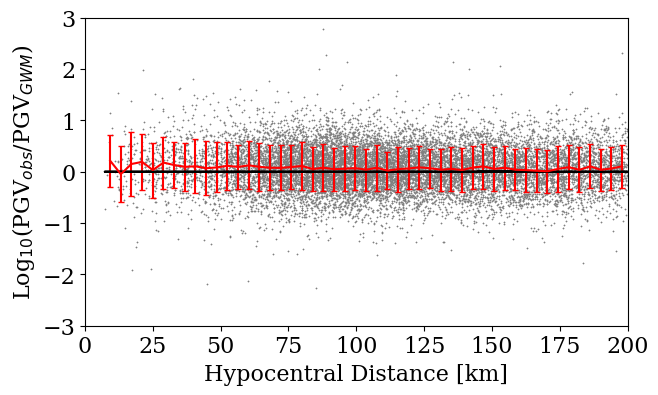

In [8]:
PGV_geom_mean_obs = dataset_generated_pgv['PGV_geom_mean_obs']
PGV_geom_mean_gm0 = dataset_generated_pgv['PGV_geom_mean_gwm']
idx_mag = mag >= 4.5

dataset_generated_stats_PGV = calculate_distance_binned_ratios(PGV_geom_mean_obs[idx_mag], PGV_geom_mean_gm0[idx_mag], data.hypocentral_distance[idx_mag], n_bins=50)

fig = plt.figure(figsize=(7,4))
ax = fig.gca()
ax.plot(data.hypocentral_distance[idx_mag], dataset_generated_stats_PGV['ratio_values'], 'o', c='grey', markersize=1, markeredgewidth=0.2, markeredgecolor='grey')
ax.errorbar(dataset_generated_stats_PGV['bin_centers'], dataset_generated_stats_PGV['median_ratios'], yerr=dataset_generated_stats_PGV['std_ratios'], color='r', capsize=2)
ax.plot(data.hypocentral_distance[idx_mag], np.ones(len(data.hypocentral_distance[idx_mag]))*0, '-', color='k')
ax.set_xlim(left=0, right=200)
ax.set_ylim(-3,3)
ax.set_xlabel("Hypocentral Distance [km]")
ax.set_ylabel("Log$_{10}$(PGV$_{obs}$/PGV$_{GWM}$)")
fig.savefig("figures/updated/ratio_PGV_distance.svg", dpi=300, bbox_inches="tight")

In [14]:
rhyp = data.hypocentral_distance[idx_mag]
it = rhyp<30
np.mean(dataset_generated_stats_PGV['ratio_values'][it]), 10**(np.mean(dataset_generated_stats_PGV['ratio_values'][it])),

(0.08847779851255956, 1.2259642287866286)

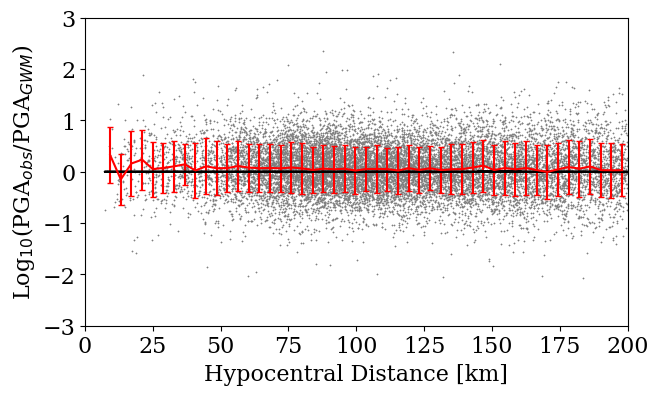

In [12]:
# PGA calculation

PGA_geom_mean_obs = dataset_generated_pga['PGA_geom_mean_obs']
PGA_geom_mean_gm0 = dataset_generated_pga['PGA_geom_mean_gwm']

dataset_generated_stats_PGA = calculate_distance_binned_ratios(PGA_geom_mean_obs[idx_mag], PGA_geom_mean_gm0[idx_mag], data.hypocentral_distance[idx_mag], n_bins=50)

fig = plt.figure(figsize=(7,4))
ax = fig.gca()
ax.plot(data.hypocentral_distance[idx_mag], dataset_generated_stats_PGA['ratio_values'], 'o', c='grey', markersize=1, markeredgewidth=0.2, markeredgecolor='grey')
ax.errorbar(dataset_generated_stats_PGA['bin_centers'], dataset_generated_stats_PGA['median_ratios'], yerr=dataset_generated_stats_PGA['std_ratios'], color='r', capsize=2)
ax.plot(data.hypocentral_distance[idx_mag], np.ones(len(data.hypocentral_distance[idx_mag]))*0, '-', color='k')
ax.set_xlim(left=0, right=200)
ax.set_ylim(-3,3)
ax.set_xlabel("Hypocentral Distance [km]")
ax.set_ylabel("Log$_{10}$(PGA$_{obs}$/PGA$_{GWM}$)")
fig.savefig("figures/updated/ratio_PGA_distance.svg", dpi=300, bbox_inches="tight")


In [15]:
np.mean(dataset_generated_stats_PGA['ratio_values'][it]), 10**(np.mean(dataset_generated_stats_PGA['ratio_values'][it]))

(0.09489388575611495, 1.2442105678560644)

In [17]:
pga_gmms_BA = []
pga_gmms_kanno = []

for i in range(len(src_lat)):
    R_epi, R_hyp, R_rup, R_jb = point_source_distances(src_lat[i], src_lon[i], depth_km[i], sta_lat[i], sta_lon[i])
    rjb = epri_epicentral_to_rjb(R_epi, mag[i])


    gmpe = BooreEtAl2014()

    site, rup, dist = build_boore_contexts_one(
        mag   = mag[i],
        rake  = 0,
        depth_km = depth_km[i],
        rjb   = rjb,
        rrup  = R_rup,
        vs30  = vs30[i]
    )

    ln_pga, _ = gmpe.get_mean_and_stddevs(
        site, rup, dist, imt.PGA(), [const.StdDev.TOTAL]
    )
    pga = np.exp(ln_pga)[0] * 9.81
    pga_gmms_BA.append(pga)
    # print("Predicted PGA:", pga)

    ######
    GMPE  = Kanno2006Shallow if depth_km[i] <= 30.0 else Kanno2006Deep
    gmpe  = GMPE()

    site, rup, dist = build_kanno_contexts_one(mag[i], depth_km[i], R_rup, vs30[i])

    ln_pga, _ = gmpe.get_mean_and_stddevs(
        site, rup, dist, imt.PGA(), [const.StdDev.TOTAL]
    )
    pga = np.exp(ln_pga)[0] * 9.81
    pga_gmms_kanno.append(pga)
    # print("Predicted PGA:", pga)

pga_gmms_BA = np.array(pga_gmms_BA)
pga_gmms_kanno = np.array(pga_gmms_kanno)

0.06085322188443643 1.1504115196882962
-0.018704379650007364 0.9578458464986278
-0.048460326409732836 0.8944162347493282
-0.026652818667907682 0.9404748394128546


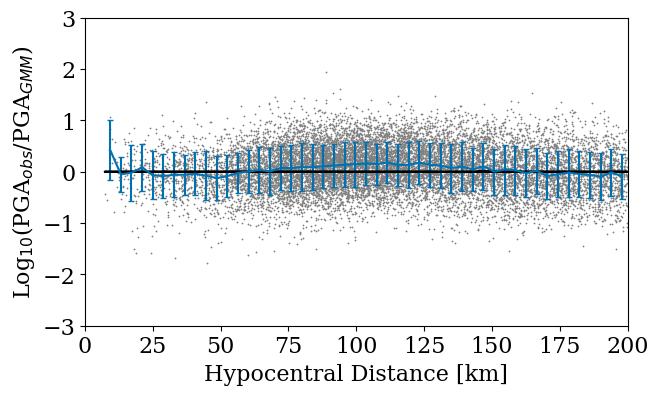

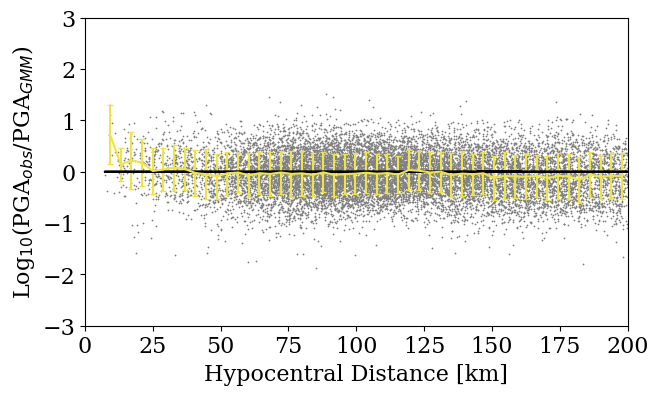

In [19]:
PGA_geom_mean_obs = dataset_generated_pga['PGA_geom_mean_obs']
PGA_geom_mean_obs_kanno = dataset_generated_pga_kanno['PGA_geom_mean_obs']

dataset_generated_stats_PGA_boore = calculate_distance_binned_ratios(PGA_geom_mean_obs[idx_mag], pga_gmms_BA[idx_mag], data.hypocentral_distance[idx_mag], n_bins=50)
dataset_generated_stats_PGA_kanno = calculate_distance_binned_ratios(PGA_geom_mean_obs_kanno[idx_mag], pga_gmms_kanno[idx_mag], data.hypocentral_distance[idx_mag], n_bins=50)

fig = plt.figure(figsize=(7,4))
ax = fig.gca()
ax.plot(data.hypocentral_distance[idx_mag], dataset_generated_stats_PGA_boore['ratio_values'], 'o', c='grey', markersize=1, markeredgewidth=0.2, markeredgecolor='grey')
ax.errorbar(dataset_generated_stats_PGA_boore['bin_centers'], dataset_generated_stats_PGA_boore['median_ratios'], yerr=dataset_generated_stats_PGA_boore['std_ratios'], color='#0072B2', capsize=2)
ax.plot(data.hypocentral_distance[idx_mag], np.ones(len(data.hypocentral_distance[idx_mag]))*0, '-', color='k')
ax.set_xlim(left=0, right=200)
ax.set_ylim(-3,3)
ax.set_xlabel("Hypocentral Distance [km]")
ax.set_ylabel("Log$_{10}$(PGA$_{obs}$/PGA$_{GMM}$)")
fig.savefig("figures/updated/residual_pga_BA.png", dpi=300, bbox_inches="tight")
fig.savefig("figures/updated/residual_pga_BA.svg", dpi=300, bbox_inches="tight")

it = rhyp<75
print(np.mean(dataset_generated_stats_PGA_boore['ratio_values']), 10**(np.mean(dataset_generated_stats_PGA_boore['ratio_values'])),)
print(np.mean(dataset_generated_stats_PGA_boore['ratio_values'][it]), 10**(np.mean(dataset_generated_stats_PGA_boore['ratio_values'][it])),)

fig = plt.figure(figsize=(7,4))
ax = fig.gca()
ax.plot(data.hypocentral_distance[idx_mag], dataset_generated_stats_PGA_kanno['ratio_values'], 'o', c='grey', markersize=1, markeredgewidth=0.2, markeredgecolor='grey')
ax.errorbar(dataset_generated_stats_PGA_kanno['bin_centers'], dataset_generated_stats_PGA_kanno['median_ratios'], yerr=dataset_generated_stats_PGA_kanno['std_ratios'], color='#F0E442', capsize=2)
ax.plot(data.hypocentral_distance[idx_mag], np.ones(len(data.hypocentral_distance[idx_mag]))*0, '-', color='k')
ax.set_xlim(left=0, right=200)
ax.set_ylim(-3,3)
ax.set_xlabel("Hypocentral Distance [km]")
ax.set_ylabel("Log$_{10}$(PGA$_{obs}$/PGA$_{GMM}$)")
fig.savefig("figures/updated/residual_pga_kanno.png", dpi=300, bbox_inches="tight")
fig.savefig("figures/updated/residual_pga_kanno.svg", dpi=300, bbox_inches="tight")

print(np.mean(dataset_generated_stats_PGA_kanno['ratio_values']), 10**(np.mean(dataset_generated_stats_PGA_kanno['ratio_values'])),)
print(np.mean(dataset_generated_stats_PGA_kanno['ratio_values'][it]), 10**(np.mean(dataset_generated_stats_PGA_kanno['ratio_values'][it])),)

In [21]:
pgv_gmms_BA = []
pgv_gmms_kanno = []

for i in range(len(src_lat)):
    R_epi, R_hyp, R_rup, R_jb = point_source_distances(src_lat[i], src_lon[i], depth_km[i], sta_lat[i], sta_lon[i])
    rjb = epri_epicentral_to_rjb(R_epi, mag[i])


    gmpe = BooreEtAl2014()

    site, rup, dist = build_boore_contexts_one(
        mag   = mag[i],
        rake  = 0,
        depth_km = depth_km[i],
        rjb   = rjb,
        rrup  = R_rup,
        vs30  = vs30[i]
    )

    ln_pgv, _ = gmpe.get_mean_and_stddevs(
        site, rup, dist, imt.PGV(), [const.StdDev.TOTAL]
    )
    pgv = np.exp(ln_pgv)[0] * 1e-2
    pgv_gmms_BA.append(pgv)
    # print("Predicted PGV:", pgv)

    ######
    GMPE  = Kanno2006Shallow if depth_km[i] <= 30.0 else Kanno2006Deep 
    gmpe  = GMPE()

    site, rup, dist = build_kanno_contexts_one(mag[i], depth_km[i], R_hyp, vs30[i])

    ln_pgv, _ = gmpe.get_mean_and_stddevs(
        site, rup, dist, imt.PGV(), [const.StdDev.TOTAL]
    )
    pgv = np.exp(ln_pgv)[0] * 1e-2 
    pgv_gmms_kanno.append(pgv)
    # print("Predicted PGV:", pgv)

pgv_gmms_BA = np.array(pgv_gmms_BA)
pgv_gmms_kanno = np.array(pgv_gmms_kanno)

-0.0335316479239656 0.9256959253142911
-0.09080009256589842 0.8113344322997279
-0.11137827216734059 0.773787532278719
0.11773579477428815 1.3114018584016003


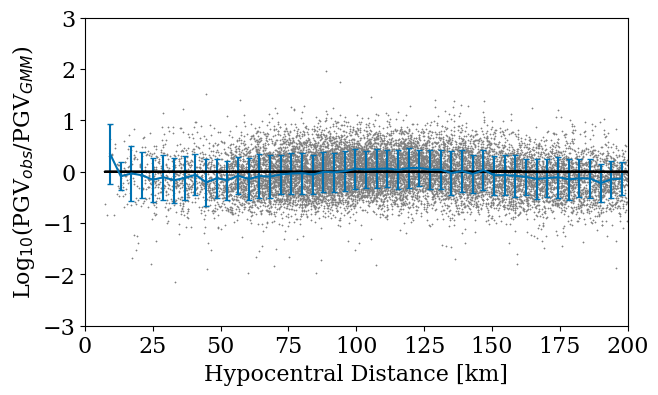

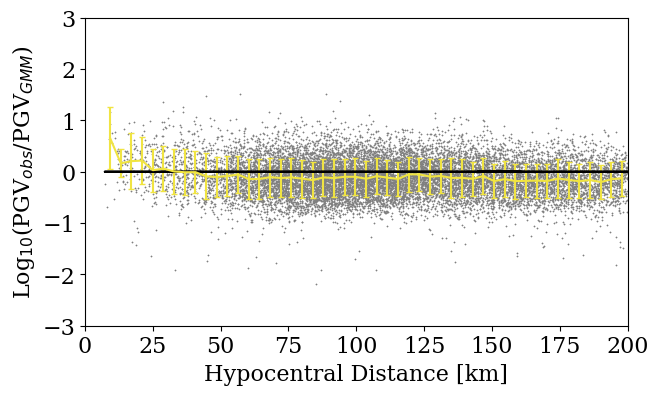

In [23]:
PGV_geom_mean_obs = dataset_generated_pgv['PGV_geom_mean_obs']
PGV_geom_mean_obs_kanno = dataset_generated_pgv_kanno['PGV_geom_mean_obs']

dataset_generated_stats_PGV_boore = calculate_distance_binned_ratios(PGV_geom_mean_obs[idx_mag], pgv_gmms_BA[idx_mag], data.hypocentral_distance[idx_mag], n_bins=50)
dataset_generated_stats_PGV_kanno = calculate_distance_binned_ratios(PGV_geom_mean_obs_kanno[idx_mag], pgv_gmms_kanno[idx_mag], data.hypocentral_distance[idx_mag], n_bins=50)


fig = plt.figure(figsize=(7,4))
ax = fig.gca()
ax.plot(data.hypocentral_distance[idx_mag], dataset_generated_stats_PGV_boore['ratio_values'], 'o', c='grey', markersize=1, markeredgewidth=0.2, markeredgecolor='grey')
ax.errorbar(dataset_generated_stats_PGV_boore['bin_centers'], dataset_generated_stats_PGV_boore['median_ratios'], yerr=dataset_generated_stats_PGV_boore['std_ratios'], color='#0072B2', capsize=2)
ax.plot(data.hypocentral_distance[idx_mag], np.ones(len(data.hypocentral_distance[idx_mag]))*0, '-', color='k')
ax.set_xlim(left=0, right=200)
ax.set_ylim(-3,3)
ax.set_xlabel("Hypocentral Distance [km]")
ax.set_ylabel("Log$_{10}$(PGV$_{obs}$/PGV$_{GMM}$)")
fig.savefig("figures/updated/residual_pgv_BA.png", dpi=300, bbox_inches="tight")
fig.savefig("figures/updated/residual_pgv_BA.svg", dpi=300, bbox_inches="tight")
# plt.close()

print(np.mean(dataset_generated_stats_PGV_boore['ratio_values']), 10**(np.mean(dataset_generated_stats_PGV_boore['ratio_values'])),)
print(np.mean(dataset_generated_stats_PGV_boore['ratio_values'][it]), 10**(np.mean(dataset_generated_stats_PGV_boore['ratio_values'][it])),)

fig = plt.figure(figsize=(7,4))
ax = fig.gca()
ax.plot(data.hypocentral_distance[idx_mag], dataset_generated_stats_PGV_kanno['ratio_values'], 'o', c='grey', markersize=1, markeredgewidth=0.2, markeredgecolor='grey')
ax.errorbar(dataset_generated_stats_PGV_kanno['bin_centers'], dataset_generated_stats_PGV_kanno['median_ratios'], yerr=dataset_generated_stats_PGV_kanno['std_ratios'], color='#F0E442', capsize=2)
ax.plot(data.hypocentral_distance[idx_mag], np.ones(len(data.hypocentral_distance[idx_mag]))*0, '-', color='k')
ax.set_xlim(left=0, right=200)
ax.set_ylim(-3,3)
ax.set_xlabel("Hypocentral Distance [km]")
ax.set_ylabel("Log$_{10}$(PGV$_{obs}$/PGV$_{GMM}$)")
# fig.savefig("figures/updated/residual_pgv_kanno.png", dpi=300, bbox_inches="tight")
# fig.savefig("figures/updated/residual_pgv_kanno.svg", dpi=300, bbox_inches="tight")
# plt.close()
it = rhyp < 25
print(np.mean(dataset_generated_stats_PGV_kanno['ratio_values']), 10**(np.mean(dataset_generated_stats_PGV_kanno['ratio_values'])),)
print(np.mean(dataset_generated_stats_PGV_kanno['ratio_values'][it]), 10**(np.mean(dataset_generated_stats_PGV_kanno['ratio_values'][it])),)

In [44]:
np.mean(dataset_generated_stats_PGV['median_ratios']), np.mean(dataset_generated_stats_PGV_kanno['median_ratios'])

(0.07638585120938902, -0.07636619771655381)